<a href="https://colab.research.google.com/github/poojasaxena/tensorflow-developer-zertificate-coursera/blob/main/course2_convolutional-neural-networks-tensorflow/05_tuning_hyperparameters/Course_2_Part_10_Lesson_2_Notebook_KerasTuner_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step1. Setup

In [ ]:
from platform import python_version
print(python_version())

3.8.0


In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [ ]:
#!pip install -q -U keras-tuner

In [ ]:
### install keras-tuner
#python3 -m pip install --user keras-tuner 
import kerastuner as kt

# Step 2. Download and prepare the dataset 

we will use the Fashion MNIST dataset, ie. images of clothing. 

In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
## lets check the number of train/test images
print('No of train images: ', img_train.shape)
print('No of test images: ', img_test.shape)
print('label format for trainig:', label_train.shape)
print('label format for testing:', label_test.shape)
print('unique lables are :', np.unique(label_train))

No of train images:  (60000, 28, 28)
No of test images:  (10000, 28, 28)
label format for trainig: (60000,)
label format for testing: (10000,)


Label of indx 2202 :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


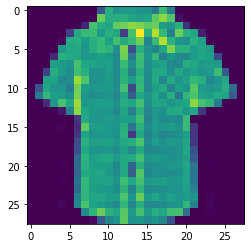

In [ ]:
## Lets visualize the dataset
import matplotlib.pyplot as plt

indx=2202
plt.imshow(img_train[indx])
print('Label of indx',indx,': ',label_train[indx])

In [ ]:
## Normalize the dataset
img_train = img_train.astype('float32')/255.0
img_test = img_test.astype('float32')/255.0

In [ ]:
img_train = img_train.reshape(list(img_train.shape) + [1])
img_test = img_test.reshape(list(img_test.shape) + [1])

# Normalize pixel values to be between 0 and 1
from tensorflow.keras.utils import to_categorical 
import numpy as np
label_train = to_categorical(label_train, len(np.unique(label_train)))
label_test = to_categorical(label_test, len(np.unique(label_test)))

# Step 3. Plotting Scripts

In [ ]:
## To plot any number of model_history for comparison
fig = plt.figure()
fig.patch.set_facecolor('white')

def plot_n_model(n=2, model_history=[],
          ylim_low=0.4, ylim_high=1.0, 
          label_list=[]    ,       
          leg_loc='lower left'):
    fig = plt.figure(figsize=(15,5))

    assert(len(model_history) ==n)
    
    variable1, variable2='accuracy','val_accuracy'
    variable3, variable4='loss', 'val_loss'
    
    color=['red','blue', 'orange', 'green', 'black', 'aqua','yellow']
    
    plt.subplot(1,2,1)
    for index, history in enumerate(model_history):
        print(index, history)
        
        plt.plot(history.history['accuracy'], label=label_list[index], c=color[index], ls='-')
        plt.plot(history.history['val_accuracy'], c=color[index],ls='--')
        plt.ylabel('accuracy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend(loc=leg_loc)
        plt.title('Training - , Validation ---')

        
    plt.subplot(1,2,2)
    for index, history in enumerate(model_history):
        plt.plot(history.history['loss'], label=label_list[index], c=color[index], ls='-')
        plt.plot(history.history['val_loss'],  c=color[index],ls='--')
        plt.title('Training - , Validation ---')

    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend(loc=leg_loc)
    plt.ylim(ylim_low,ylim_high)

<Figure size 432x288 with 0 Axes>

# Step 4. Define model

while building a model for hypertuning, one should define the hyperparamet search spave in addition to the model architecture.
The model setup for hypertuning is called a hypermodel. It could be defined through two approaches:
    
    * By using a model builder function
    * By subclassing the HyperModel class of the Keras Tuner API

In [ ]:
from kerastuner import HyperModel


class CustomHyperModel(HyperModel):

    def __init__(self, isvgg=False, L1=0):
        self.isvgg = isvgg
        self.L1=L1
        
    def build(self, hp):
        if self.isvgg:
            INPUT_SHAPE= (28, 28, 1)
        else:
            INPUT_SHAPE=(28,28)

        
        model= keras.Sequential()                
    
        if(self.isvgg):
            # First Layer
            model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',input_shape=INPUT_SHAPE))
            model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
            model.add(keras.layers.MaxPooling2D(2, 2))
        
            # The second convolution
            model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
            model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
            model.add(keras.layers.MaxPooling2D(2,2))
        
            # The third convolution
            model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
            model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
            model.add(keras.layers.MaxPooling2D(2,2))
            model.add(keras.layers.Flatten())
        else:
            model.add(keras.layers.Flatten(input_shape=INPUT_SHAPE))

        hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
        model.add(keras.layers.Dense(units=hp_units, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(l1=self.L1)))
        model.add(keras.layers.Dense(10, activation='softmax'))
    
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
        model.summary()
        return model

## Step 4.1 Simple Model

### Instentiate the tuner and perform hypertuning

1. keras tuner has four tuners: RandomSearch, Hyperband, BayesianOptimization and Sklearn
2. To instentiate the Hyperband tuner, one must specify the hypermodel, the 'pobjective' to optimize and the  maximum number of epoches to train 'max_epochs'

In [ ]:
## ?kt.Hyperband

In [ ]:
simple_hypermodel = CustomHyperModel()
tuner = kt.Hyperband(simple_hypermodel, 
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3, # Int. Reduction factor for the number of epochs/number of models for each bracket.
                    directory='my_dir',
                    project_name='intro_to_tuning')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_tuning/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_tuning/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(img_train, label_train, epochs=15, validation_split=0.2, callbacks=[stop_early])

## get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The Optimal number of units in the first dense layeer is {best_hps.get('units')} and 
the optimal learning rate for the optimal learning_rate is {best_hps.get('learning_rate')}""")

Trial 29 Complete [00h 00m 35s]
val_accuracy: 0.8820833563804626

Best val_accuracy So Far: 0.8820833563804626
Total elapsed time: 00h 05m 23s
INFO:tensorflow:Oracle triggered exit

The Optimal number of units in the first dense layeer is 448 and 
the optimal learning rate for the optimal learning_rate is 0.0001


### Train the Model

Find the optimal number of epoches to train the model with the hyperparameter obrained from the search.



In [ ]:
# Build the model with the optimal hyperparamers and train it on the data for 15 epochs
model=tuner.hypermodel.build(best_hps)
history=model.fit(img_train, label_train, epochs=20, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) +1
print('Best epoch: %d' % (best_epoch,))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 448)               351680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                4490      
Total params: 356,170
Trainable params: 356,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.8739 - accuracy: 0.7220 - val_loss: 0.4724 - val_accuracy: 0.8392
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4581 - accuracy: 0.8462 - val_loss: 0.4349 - val_accuracy: 0.8502
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4021 - accurac

In [ ]:
## Reinstiate the hypermodel and train it with optimal nunber of epoches
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 448)               351680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                4490      
Total params: 356,170
Trainable params: 356,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/19
1500/1500 [==============================] - 4s 2ms/step - loss: 0.8694 - accuracy: 0.7297 - val_loss: 0.4809 - val_accuracy: 0.8341
Epoch 2/19
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4502 - accuracy: 0.8461 - val_loss: 0.4219 - val_accuracy: 0.8528
Epoch 3/19
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4065 - accurac

0 <tensorflow.python.keras.callbacks.History object at 0x7f4eb0791910>


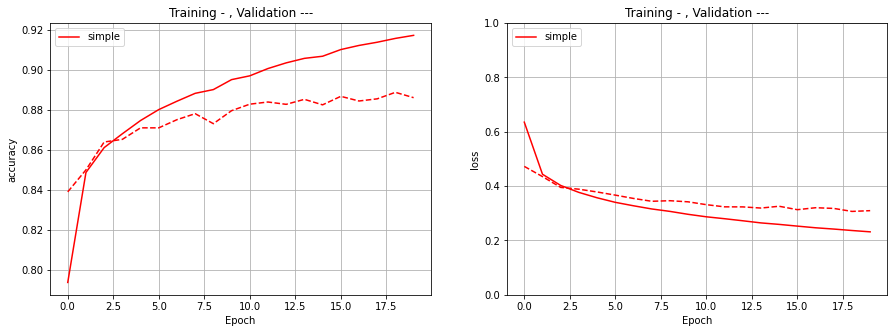

In [ ]:
plot_n_model(n=1, model_history=[history], label_list=['simple'],ylim_low=0, leg_loc='upper left')

###  Evaluate on test data

In [ ]:
## Evaluate the hyoermodel on the test data
eval_result =hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 1ms/step - loss: 0.3296 - accuracy: 0.8837
[test loss, test accuracy]: [0.32956886291503906, 0.8837000131607056]


## Step 4.2  VGG model

In [ ]:
hypermodel = CustomHyperModel(isvgg=True)

tuner_vgg = kt.Hyperband(hypermodel, 
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3, # Int. Reduction factor for the number of epochs/number of models for each bracket.
                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [ ]:
tuner_vgg.search(img_train, label_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

## get the optimal hyperparameters
best_hp_vgg=tuner_vgg.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The Optimal number of units in the first dense layeer is {best_hp_vgg.get('units')} and 
the optimal learning rate for the optimal learning_rate is {best_hp_vgg.get('learning_rate')}""")

Trial 30 Complete [00h 14m 07s]
val_accuracy: 0.9265000224113464

Best val_accuracy So Far: 0.9265000224113464
Total elapsed time: 03h 02m 10s
INFO:tensorflow:Oracle triggered exit

The Optimal number of units in the first dense layeer is 224 and 
the optimal learning rate for the optimal learning_rate is 0.001


In [ ]:
# Build the model with the optimal hyperparamers and train it on the data for 50 epochs
model_vgg=tuner_vgg.hypermodel.build(best_hp_vgg)
history_vgg=model_vgg.fit(img_train, label_train, epochs=20, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [ ]:
val_acc_per_epoch_vgg = history_vgg.history['val_accuracy']
best_epoch_vgg = val_acc_per_epoch_vgg.index(max(val_acc_per_epoch_vgg)) +1
print('Best epoch: %d' % (best_epoch_vgg,))

Best epoch: 18


In [ ]:
## Reinstiate the hypermodel and train it with optimal number of epoches
hypermodel_vgg = tuner_vgg.hypermodel.build(best_hp_vgg)
hypermodel_vgg.fit(img_train, label_train, epochs=best_epoch_vgg, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [ ]:
## Evaluate the hyoermodel on the test data
eval_result_vgg =hypermodel_vgg.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result_vgg)

313/313 [==============================] - 5s 15ms/step - loss: 0.4562 - accuracy: 0.9161
[test loss, test accuracy]: [0.45617392659187317, 0.916100025177002]


0 <tensorflow.python.keras.callbacks.History object at 0x7f4e84d89700>


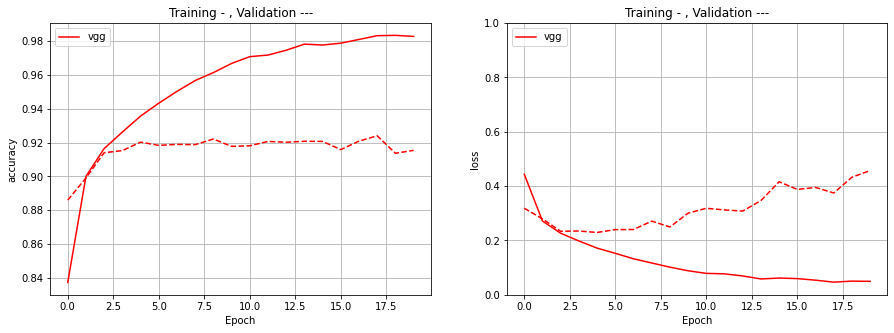

In [ ]:
plot_n_model(n=1, model_history=[history_vgg], label_list=['vgg'],ylim_low=0, leg_loc='upper left')

0 <tensorflow.python.keras.callbacks.History object at 0x7f4eb0791910>
1 <tensorflow.python.keras.callbacks.History object at 0x7f4e84d89700>


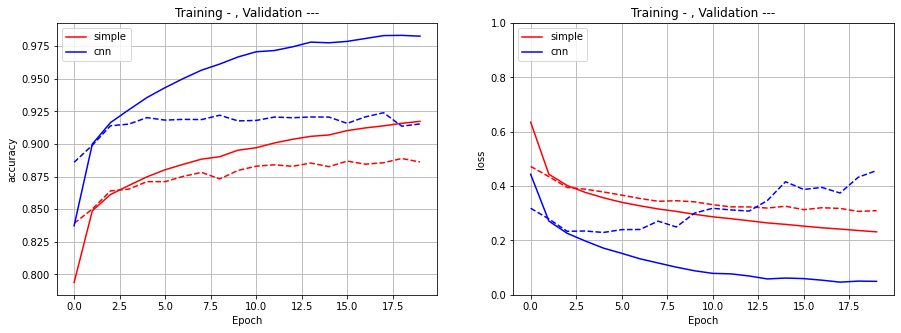

In [ ]:
plot_n_model(n=2, model_history=[history, history_vgg], label_list=['simple','cnn'],ylim_low=0, leg_loc='upper left')

### Plotting
1. As we observe, the validation accuracy (92%) is bit better than the no-cnn model (88%).
2. However, the loss plot also make it clear that we are doing overtraining.
3. Lets loosen the model and use Regularization

## Step 4.3 VGG with L1 Regularization

In [ ]:
hypermodel_vgg_L1 = CustomHyperModel(isvgg=True, L1=0.001)
tuner_vgg_L1reg = kt.Hyperband(hypermodel_vgg_L1, 
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3, # Int. Reduction factor for the number of epochs/number of models for each bracket.
                        )

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
____________________________________

In [ ]:
tuner_vgg_L1reg.search(img_train, label_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

## get the optimal hyperparameters
best_hp_vgg_L1reg=tuner_vgg_L1reg.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The Optimal number of units in the first dense layeer is {best_hp_vgg_L1reg.get('units')} and 
the optimal learning rate for the optimal learning_rate is {best_hp_vgg_L1reg.get('learning_rate')}""")

Trial 12 Complete [00h 08m 09s]
val_accuracy: 0.10266666859388351

Best val_accuracy So Far: 0.9265000224113464
Total elapsed time: 01h 39m 15s
INFO:tensorflow:Oracle triggered exit

The Optimal number of units in the first dense layeer is 224 and 
the optimal learning rate for the optimal learning_rate is 0.001


In [ ]:
# Build the model with the optimal hyperparamers and train it on the data for 20 epochs
model_vgg_L1reg=tuner_vgg_L1reg.hypermodel.build(best_hp_vgg_L1reg)
history_vgg_L1reg=model_vgg_L1reg.fit(img_train, label_train, epochs=20, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [ ]:
val_acc_per_epoch_vgg_L1reg = history_vgg_L1reg.history['val_accuracy']
best_epoch_vgg_L1reg = val_acc_per_epoch_vgg_L1reg.index(max(val_acc_per_epoch_vgg_L1reg)) +1
print('Best epoch: %d' % (best_epoch_vgg_L1reg,))

Best epoch: 12


In [ ]:
## Reinstiate the hypermodel and train it with optimal number of epoches
hypermodel_vgg_L1reg = tuner_vgg_L1reg.hypermodel.build(best_hp_vgg_L1reg)
hypermodel_vgg_L1reg.fit(img_train, label_train, epochs=best_epoch_vgg_L1reg, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [ ]:
## Evaluate the hyoermodel on the test data
eval_result_vgg_L1reg =hypermodel_vgg_L1reg.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result_vgg_L1reg)

313/313 [==============================] - 4s 11ms/step - loss: 0.3536 - accuracy: 0.9097
[test loss, test accuracy]: [0.3535778522491455, 0.9096999764442444]


### Plotting

0 <tensorflow.python.keras.callbacks.History object at 0x7f4e6ecb13a0>


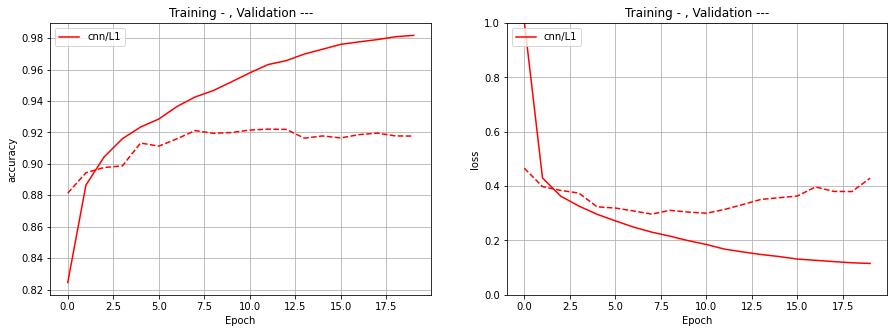

In [ ]:
plot_n_model(n=1, model_history=[history_vgg_L1reg], label_list=['cnn/L1'],ylim_low=0, leg_loc='upper left')

0 <tensorflow.python.keras.callbacks.History object at 0x7f4eb0791910>
1 <tensorflow.python.keras.callbacks.History object at 0x7f4e84d89700>
2 <tensorflow.python.keras.callbacks.History object at 0x7f4e6ecb13a0>


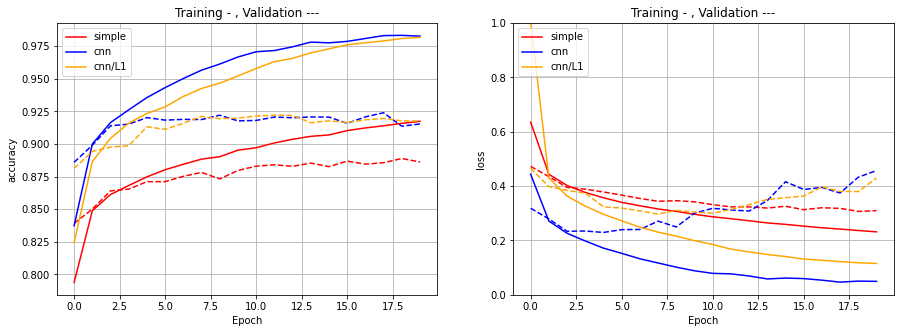

In [ ]:
plot_n_model(n=3, model_history=[history, history_vgg, history_vgg_L1reg], label_list=['simple','cnn','cnn/L1'],ylim_low=0, leg_loc='upper left')

## Referenz.

[kerastuner_on_RandomForest](https://github.com/keras-team/keras-tuner)